In [6]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import shap
import matplotlib.pyplot as plt


In [7]:
df = pd.read_csv('cardio_train.csv', sep = ';')
print(df['gender'].value_counts()) # 1 - women, 2 - men
print(df.head())

gender
1    45530
2    24470
Name: count, dtype: int64
   id    age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
0   0  18393       2     168    62.0    110     80            1     1      0   
1   1  20228       1     156    85.0    140     90            3     1      0   
2   2  18857       1     165    64.0    130     70            3     1      0   
3   3  17623       2     169    82.0    150    100            1     1      0   
4   4  17474       1     156    56.0    100     60            1     1      0   

   alco  active  cardio  
0     0       1       0  
1     0       1       1  
2     0       0       1  
3     0       1       1  
4     0       0       0  


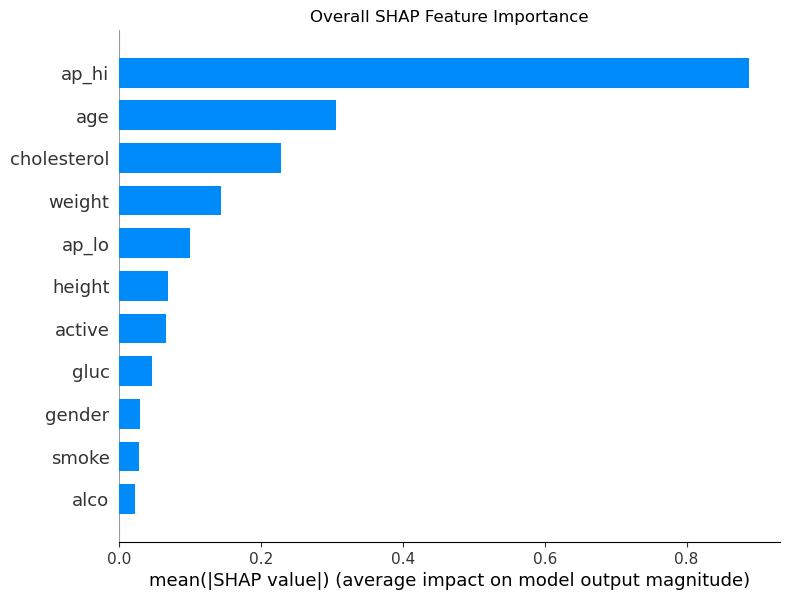

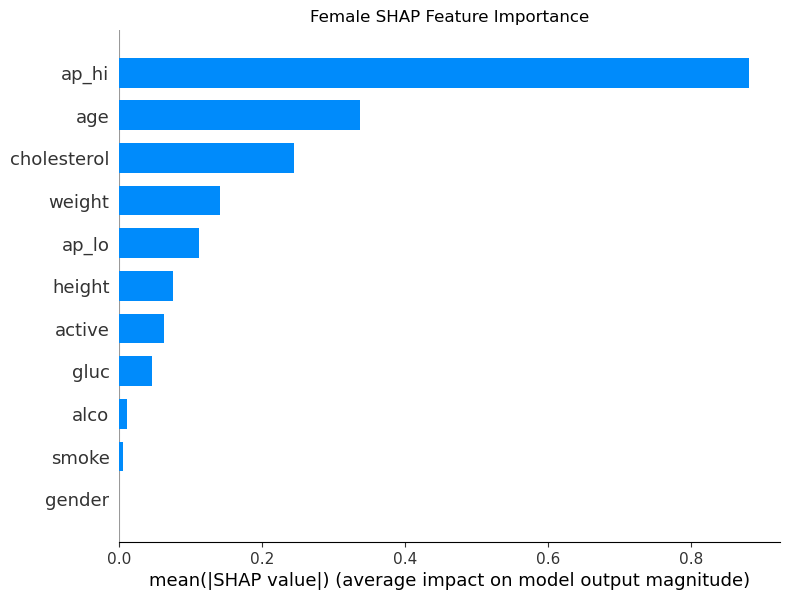

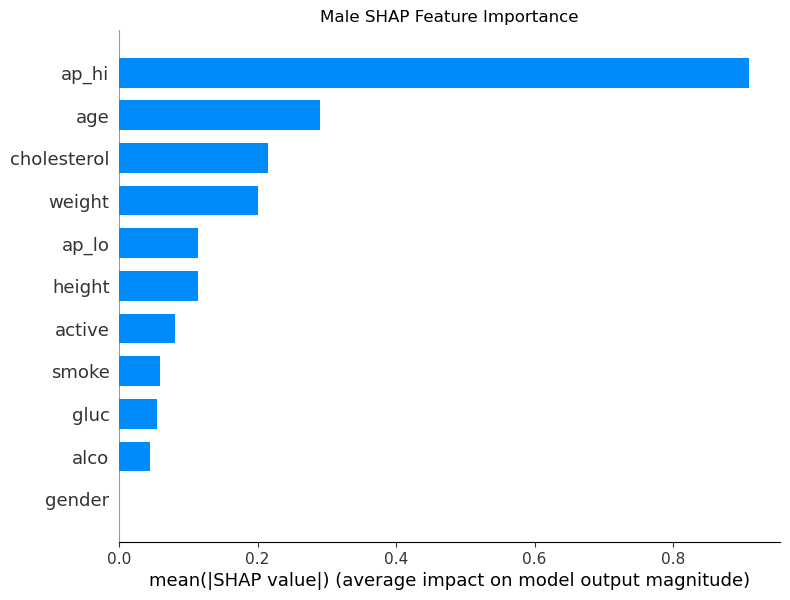

Overall Top Features:
[('ap_hi', 0.8874202), ('age', 0.3051957), ('cholesterol', 0.22802782), ('weight', 0.1433473), ('ap_lo', 0.10004836), ('height', 0.06826501), ('active', 0.06547116), ('gluc', 0.04618748), ('gender', 0.028677287), ('smoke', 0.027770441)]

Female Top Features:
[('ap_hi', 0.88035387), ('age', 0.33636692), ('cholesterol', 0.24507727), ('weight', 0.14165327), ('ap_lo', 0.11172335), ('height', 0.075309835), ('active', 0.06279671), ('gluc', 0.045711473), ('alco', 0.010445318), ('smoke', 0.00556213)]

Male Top Features:
[('ap_hi', 0.9091564), ('age', 0.29034367), ('cholesterol', 0.21491578), ('weight', 0.19988416), ('ap_lo', 0.1141899), ('height', 0.11361416), ('active', 0.080396324), ('smoke', 0.058776107), ('gluc', 0.055061564), ('alco', 0.04398999)]


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
import xgboost as xgb
from sklearn.preprocessing import StandardScaler

# ----------------------------
# 1. Load Data & Preprocessing
# ----------------------------
# Read the dataset (adjust the path as needed)
df = pd.read_csv('cardio_train.csv', sep=';')

# Drop the ID column as it is not a predictor
df.drop(columns=['id'], inplace=True)

# Define target and features
target = 'cardio'
features = [col for col in df.columns if col != target]

# Identify numerical columns for scaling (adjust if needed)
num_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']

# Instantiate scaler and scale the numerical features
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

# ----------------------------
# 2. Split the Dataset by Gender
# ----------------------------
# According to the dataset: 1 = female, 2 = male
df_female = df[df['gender'] == 1].copy()
df_male = df[df['gender'] == 2].copy()

def preprocess_subset(df_subset, target):
    """
    - Assumes df_subset[num_cols] is already scaled.
    - Returns X (features) and y (label).
    """
    X = df_subset.drop(columns=[target])
    y = df_subset[target]
    return X, y

# Get features and labels for each subset
X_overall = df.drop(columns=[target])
y_overall = df[target]

X_female, y_female = preprocess_subset(df_female, target)
X_male, y_male = preprocess_subset(df_male, target)

# ----------------------------
# 3. Train Models
# ----------------------------
def train_model(X, y):
    """
    Train an XGBoost classifier.
    """
    model = xgb.XGBClassifier(eval_metric='logloss')
    model.fit(X, y)
    return model

# Train on overall, female-only, and male-only data
model_overall = train_model(X_overall, y_overall)
model_female = train_model(X_female, y_female)
model_male = train_model(X_male, y_male)

# ----------------------------
# 4. SHAP Feature Importance Analysis
# ----------------------------
# Initialize SHAP explainers
explainer_overall = shap.Explainer(model_overall)
shap_values_overall = explainer_overall(X_overall)

explainer_female = shap.Explainer(model_female)
shap_values_female = explainer_female(X_female)

explainer_male = shap.Explainer(model_male)
shap_values_male = explainer_male(X_male)

# Plot SHAP summary (bar plot) for each group
plt.figure()
shap.summary_plot(shap_values_overall, X_overall, plot_type="bar", show=False)
plt.title('Overall SHAP Feature Importance')
plt.show()

plt.figure()
shap.summary_plot(shap_values_female, X_female, plot_type="bar", show=False)
plt.title('Female SHAP Feature Importance')
plt.show()

plt.figure()
shap.summary_plot(shap_values_male, X_male, plot_type="bar", show=False)
plt.title('Male SHAP Feature Importance')
plt.show()

# ----------------------------
# 5. Extract and Report Top Features
# ----------------------------
def get_top_features(shap_values, X, top_n=10):
    """
    Compute the mean absolute SHAP value for each feature and return the top features.
    """
    mean_shap = np.abs(shap_values.values).mean(axis=0)
    feature_importance = dict(zip(X.columns, mean_shap))
    top_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)[:top_n]
    return top_features

print("Overall Top Features:")
print(get_top_features(shap_values_overall, X_overall))

print("\nFemale Top Features:")
print(get_top_features(shap_values_female, X_female))

print("\nMale Top Features:")
print(get_top_features(shap_values_male, X_male))


Performance for Female Patients (Original Data):
              precision    recall  f1-score   support

           0       0.71      0.78      0.74      5699
           1       0.76      0.68      0.72      5688

    accuracy                           0.73     11387
   macro avg       0.73      0.73      0.73     11387
weighted avg       0.73      0.73      0.73     11387

Performance for Male Patients (Original Data):
              precision    recall  f1-score   support

           0       0.73      0.76      0.75      3056
           1       0.75      0.72      0.73      3057

    accuracy                           0.74      6113
   macro avg       0.74      0.74      0.74      6113
weighted avg       0.74      0.74      0.74      6113

Fairness Metrics by Gender:
             TPR       FPR
gender                    
1       0.682138  0.220214
2       0.715080  0.236257


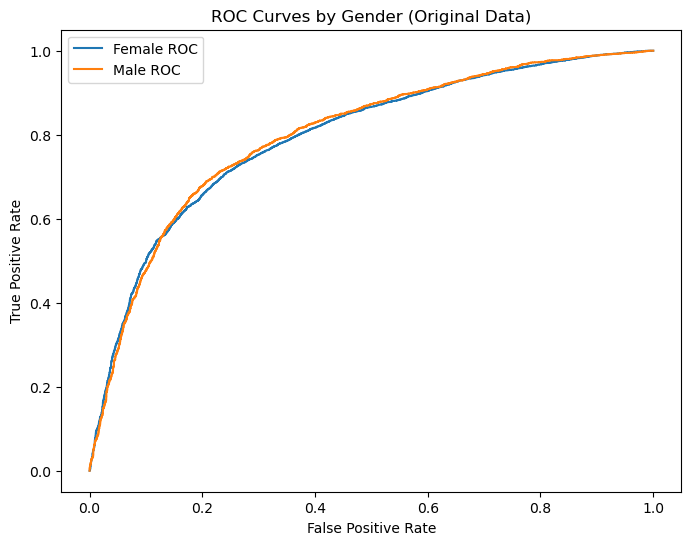

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_curve
from fairlearn.metrics import MetricFrame, true_positive_rate, false_positive_rate

# ----------------------------
# 1. Load Data & Preprocessing
# ----------------------------
df = pd.read_csv('cardio_train.csv', sep=';')

# Drop the ID column as it is not a predictor
df.drop(columns=['id'], inplace=True)

# Define target and features
target = 'cardio'
features = [col for col in df.columns if col != target]

# Identify numerical columns for scaling
num_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']

# Instantiate scaler and scale the numerical features
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

# ----------------------------
# 2. Split the Dataset by Gender for Separate Analysis (if needed)
# ----------------------------
# According to the dataset: 1 = female, 2 = male
df_female = df[df['gender'] == 1].copy()
df_male = df[df['gender'] == 2].copy()

def preprocess_subset(df_subset, target):
    """
    - Assumes df_subset[num_cols] is already scaled.
    - Returns X (features) and y (label).
    """
    X = df_subset.drop(columns=[target])
    y = df_subset[target]
    return X, y

X_overall = df.drop(columns=[target])
y_overall = df[target]

X_female, y_female = preprocess_subset(df_female, target)
X_male, y_male = preprocess_subset(df_male, target)

# ----------------------------
# 3. Evaluate on the Original (Imbalanced) Dataset
# ----------------------------
# Split the original dataset with stratification by target
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(
    X_overall, y_overall, test_size=0.25, random_state=0, stratify=y_overall)

# Train an XGBoost classifier on the original unbalanced data
model_RF_orig = xgb.XGBClassifier(eval_metric='logloss', random_state=0)
model_RF_orig.fit(X_train_orig, y_train_orig)

# Overall performance
y_pred_orig = model_RF_orig.predict(X_test_orig)
# print("Overall Performance on Original Data:")
# print(classification_report(y_test_orig, y_pred_orig))

# ----------------------------
# 4. Evaluate Performance by Gender
# ----------------------------
# Separate the test set by gender
X_test_orig_female = X_test_orig[X_test_orig['gender'] == 1]
y_test_orig_female = y_test_orig[X_test_orig['gender'] == 1]
X_test_orig_male = X_test_orig[X_test_orig['gender'] == 2]
y_test_orig_male = y_test_orig[X_test_orig['gender'] == 2]

y_pred_orig_female = model_RF_orig.predict(X_test_orig_female)
y_pred_orig_male = model_RF_orig.predict(X_test_orig_male)

print("Performance for Female Patients (Original Data):")
print(classification_report(y_test_orig_female, y_pred_orig_female))
print("Performance for Male Patients (Original Data):")
print(classification_report(y_test_orig_male, y_pred_orig_male))

# ----------------------------
# 5. Fairness Metrics Using Fairlearn
# ----------------------------
# Calculate TPR and FPR for each gender group
metrics = {'TPR': true_positive_rate, 'FPR': false_positive_rate}
mf = MetricFrame(metrics=metrics,
                 y_true=y_test_orig,
                 y_pred=y_pred_orig,
                 sensitive_features=X_test_orig['gender'])
print("Fairness Metrics by Gender:")
print(mf.by_group)

# ----------------------------
# 6. ROC Curves by Gender
# ----------------------------
# Obtain predicted probabilities for the positive class
y_prob_female = model_RF_orig.predict_proba(X_test_orig_female)[:, 1]
y_prob_male = model_RF_orig.predict_proba(X_test_orig_male)[:, 1]

# Compute ROC curves for each gender
fpr_f, tpr_f, _ = roc_curve(y_test_orig_female, y_prob_female)
fpr_m, tpr_m, _ = roc_curve(y_test_orig_male, y_prob_male)

plt.figure(figsize=(8, 6))
plt.plot(fpr_f, tpr_f, label='Female ROC')
plt.plot(fpr_m, tpr_m, label='Male ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves by Gender (Original Data)')
plt.legend()
plt.show()


## After Midterm

In [10]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from fairlearn.metrics import MetricFrame, true_positive_rate, false_positive_rate
from imblearn.over_sampling import SMOTENC   # ← NEW

# ----------------------------
# 1. Load & Preprocess (unchanged)
# ----------------------------
df = pd.read_csv('cardio_train.csv', sep=';').drop(columns=['id'])
target = 'cardio'
num_cols = ['age','height','weight','ap_hi','ap_lo']
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

# ----------------------------
# 2. Train/Test Split
# ----------------------------
X = df.drop(columns=[target])
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=0, stratify=y
)

# ----------------------------
# 3. Helper: balance one gender with SMOTE-NC
# ----------------------------
cat_cols = ['gender','cholesterol','gluc','smoke','alco','active']
cat_idx  = [X_train.columns.get_loc(c) for c in cat_cols]

def smote_balance_gender(X_part, y_part, random_state=0):
    sm = SMOTENC(categorical_features=cat_idx, random_state=random_state)
    X_res, y_res = sm.fit_resample(X_part, y_part)
    return pd.DataFrame(X_res, columns=X_part.columns), pd.Series(y_res, name=target)

# ----------------------------
# 4. Apply SMOTE-NC inside each gender
# ----------------------------
mask_f = X_train['gender'] == 1
mask_m = X_train['gender'] == 2

X_f_bal, y_f_bal = smote_balance_gender(X_train[mask_f], y_train[mask_f])
X_m_bal, y_m_bal = smote_balance_gender(X_train[mask_m], y_train[mask_m])

# Concatenate balanced subsets
X_train_bal = pd.concat([X_f_bal, X_m_bal], ignore_index=True)
y_train_bal = pd.concat([y_f_bal, y_m_bal], ignore_index=True)

# print("Cardio class counts after SMOTE-NC:")
# print(pd.crosstab(X_train_bal['gender'], y_train_bal))

# ----------------------------
# 5. Train model
# ----------------------------
model = xgb.XGBClassifier(eval_metric='logloss', random_state=0)
model.fit(X_train_bal, y_train_bal)

# ----------------------------
# 6. Evaluate
# ----------------------------
y_pred = model.predict(X_test)

for g, name in [(1,'Female'), (2,'Male')]:
    m = X_test['gender'] == g
    print(f"\n--- {name} Performance ---")
    print(classification_report(y_test[m], y_pred[m]))

mf = MetricFrame(
    metrics={'TPR': true_positive_rate, 'FPR': false_positive_rate},
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=X_test['gender']
)
print("\n=== Fairness Metrics by Gender ===")
print(mf.by_group)


--- Female Performance ---
              precision    recall  f1-score   support

           0       0.71      0.77      0.74      5699
           1       0.75      0.69      0.72      5688

    accuracy                           0.73     11387
   macro avg       0.73      0.73      0.73     11387
weighted avg       0.73      0.73      0.73     11387


--- Male Performance ---
              precision    recall  f1-score   support

           0       0.72      0.76      0.74      3056
           1       0.75      0.71      0.73      3057

    accuracy                           0.74      6113
   macro avg       0.74      0.74      0.74      6113
weighted avg       0.74      0.74      0.74      6113


=== Fairness Metrics by Gender ===
             TPR       FPR
gender                    
1       0.688994  0.230918
2       0.706902  0.235275


In [16]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from fairlearn.metrics import MetricFrame, true_positive_rate, false_positive_rate

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Layer, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

# 1. Load & preprocess
df = pd.read_csv('cardio_train.csv', sep=';').drop(columns=['id'])
target = 'cardio'
num_cols = ['age','height','weight','ap_hi','ap_lo']
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

X = df.drop(columns=[target]).values
y = df[target].values
s = (df['gender'].values - 1)  # 0=female, 1=male

# 2. Train/test split
X_train, X_test, y_train, y_test, s_train, s_test = train_test_split(
    X, y, s, test_size=0.25, random_state=0, stratify=y
)

# 3. Gradient Reversal Layer (tunable λ)
class GradientReversal(Layer):
    def __init__(self, hp_lambda=5.0, **kwargs):
        super().__init__(**kwargs)
        self.hp_lambda = hp_lambda

    def call(self, x):
        @tf.custom_gradient
        def _reverse(x):
            def grad(dy):
                return -self.hp_lambda * dy
            return x, grad
        return _reverse(x)

# 4. Build the adversarial model
inp = Input(shape=(X_train.shape[1],), name='features')

# Shared encoder
x = Dense(128, activation='relu')(inp)
x = Dropout(0.3)(x)
rep = Dense(64, activation='relu', name='repr')(x)

# Predictor head
pred_out = Dense(1, activation='sigmoid', name='pred')(rep)

# Stronger adversary head
rev = GradientReversal(hp_lambda=5.0)(rep)
adv_x = Dense(64, activation='relu')(rev)
adv_x = Dropout(0.3)(adv_x)
adv_out = Dense(1, activation='sigmoid', name='adv')(adv_x)

model = Model(inputs=inp, outputs=[pred_out, adv_out])
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss={'pred':'binary_crossentropy', 'adv':'binary_crossentropy'},
    loss_weights={'pred':1.0, 'adv':1.0},
    metrics={'pred':'accuracy'}
)

# 5. Train with early stopping on predictor loss
es = EarlyStopping(
    monitor='val_pred_loss', 
    patience=5, 
    restore_best_weights=True,
    mode='min'  # ← explicitly minimize the validation loss
)
model.fit(
    X_train,
    {'pred': y_train, 'adv': s_train},
    epochs=100,
    batch_size=128,
    validation_split=0.1,
    callbacks=[es],
    verbose=2
)

# 6. Evaluate predictor
y_pred_prob, _ = model.predict(X_test)
y_pred = (y_pred_prob.flatten() > 0.5).astype(int)

print("=== Overall Performance ===")
print(classification_report(y_test, y_pred))

mf = MetricFrame(
    metrics={'TPR': true_positive_rate, 'FPR': false_positive_rate},
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=s_test
)
print("=== Fairness Metrics by Gender ===")
print(mf.by_group)

Epoch 1/100
370/370 - 1s - 3ms/step - adv_loss: 0.7070 - loss: 1.3977 - pred_accuracy: 0.5268 - pred_loss: 0.6905 - val_adv_loss: 0.6652 - val_loss: 1.3296 - val_pred_accuracy: 0.6213 - val_pred_loss: 0.6608
Epoch 2/100
370/370 - 0s - 874us/step - adv_loss: 0.6642 - loss: 1.3207 - pred_accuracy: 0.6160 - pred_loss: 0.6565 - val_adv_loss: 0.6664 - val_loss: 1.3078 - val_pred_accuracy: 0.6463 - val_pred_loss: 0.6361
Epoch 3/100
370/370 - 0s - 846us/step - adv_loss: 0.6669 - loss: 1.3088 - pred_accuracy: 0.6323 - pred_loss: 0.6429 - val_adv_loss: 0.6397 - val_loss: 1.2698 - val_pred_accuracy: 0.6463 - val_pred_loss: 0.6235
Epoch 4/100
370/370 - 0s - 860us/step - adv_loss: 0.6623 - loss: 1.3000 - pred_accuracy: 0.6381 - pred_loss: 0.6377 - val_adv_loss: 0.6359 - val_loss: 1.2611 - val_pred_accuracy: 0.6547 - val_pred_loss: 0.6180
Epoch 5/100
370/370 - 0s - 961us/step - adv_loss: 0.6631 - loss: 1.2970 - pred_accuracy: 0.6413 - pred_loss: 0.6344 - val_adv_loss: 0.6358 - val_loss: 1.2587 - va